### INDICE
* [**1) Librerías, configuraciones y upload del dataset**](#section_lib_config)
* [**2) Primer aproach al dataset**](#section_1st_aproach)
    * [Primeras observaciones de la data](#section_1st_obs)
    * [Análisis features de scores de matcheo](#section_feat_scores)
* [**3) Data Wrangling**](#section_data_wrangling)
    * [Feature removal n1](#section_feat_remov1)
    * [Precio MELI final](#section_precio_meli_final)
* [**3) EDA / Data Cleaning**](#section_eda) 
    * [Capeo](#section_capeo)
    * [Tratamiento de duplicados](#section_duplicados)

# 1) Librerías, configuraciones y upload del dataset <a id='section_lib_config'></a>

In [1]:
# Librerías y modulos
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from pandas.io import gbq
from datetime import datetime
import warnings

In [3]:
# Configuraciones de la notebook
pd.set_option('display.max_columns', 500)
#pd.set_option('display.width', 1000)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
# warnings
warnings.filterwarnings("ignore")

In [4]:
# Importar tabla de Big Query
# df_meli = gbq.read_gbq("SELECT * FROM `data-team-k.pricing_data.meli_match`", project_id="data-team-k")

In [5]:
# Descargarlo como pickle
# fecha = datetime.today().strftime('%Y-%m-%d')
# df_meli.to_pickle(f'df_meli_{fecha}.pkl')

In [3]:
# Upload del pickle
df_meli = pd.read_pickle('df_meli_2021-12-20.pkl')

In [92]:
df_meli.date.max()

Timestamp('2021-12-19 00:00:00')

# 2) Primer aproach al dataset <a id='section_1st_aproach'></a>

**Primeras observaciones de la data** <a id='section_1st_obs'></a>

In [7]:
df_meli.shape

(3104549, 42)

In [8]:
df_meli.columns

Index(['runtime', 'date', 'timestamp', 'date_hour', 'price_symbol',
       'price_amount_txt', 'price_amount', 'car_year', 'car_kms_txt',
       'car_kms', 'km', 'car_title', 'car_location', 'car_location_0',
       'car_location_1', 'car_link', 'car_id', 'year', 'brand', 'model',
       'version', 'dealer', 'match_marca_a', 'score_marca_a', 'match_modelo_a',
       'score_modelo_a', 'match_v1_a', 'score_v1_a', 'total_score_a', 'Seg_a',
       'Subseg_a', 'gama_a', 'match_marca_c', 'score_marca_c',
       'match_modelo_c', 'score_modelo_c', 'match_v1_c', 'score_v1_c',
       'total_score_c', 'Seg_c', 'Subseg_c', 'gama_c'],
      dtype='object')

In [9]:
# Cardinalidad de las features categoricas
cardinalidad = df_meli.select_dtypes(include='object').nunique().sort_values(ascending=False)
cardinalidad

car_link            2822280
car_id               149284
price_amount_txt      27269
car_title             15147
version               13175
car_kms_txt            9361
match_v1_a             3211
match_v1_c             2735
model                   625
car_location            601
car_location_0          525
match_modelo_c          422
match_modelo_a          409
brand                    52
match_marca_c            48
match_marca_a            46
Subseg_c                 29
car_location_1           29
Subseg_a                 26
Seg_c                     9
Seg_a                     8
gama_c                    3
gama_a                    3
price_symbol              2
dtype: int64

In [10]:
df_meli.iloc[:100,].head()

,runtime,date,timestamp,date_hour,price_symbol,price_amount_txt,price_amount,car_year,car_kms_txt,car_kms,km,car_title,car_location,car_location_0,car_location_1,car_link,car_id,year,brand,model,version,dealer,match_marca_a,score_marca_a,match_modelo_a,score_modelo_a,match_v1_a,score_v1_a,total_score_a,Seg_a,Subseg_a,gama_a,match_marca_c,score_marca_c,match_modelo_c,score_modelo_c,match_v1_c,score_v1_c,total_score_c,Seg_c,Subseg_c,gama_c
0,2021-12-02 08:01:23.575469+00:00,2021-12-02,2021-12-02 08:03:06.844280+00:00,NaT,U$S,105.000,105000.0000,2021,0 Km,0.0000,True,Jeep Grand Cherokee 3.6 Limited 286hp Techo + ...,Biedma - Chubut,Biedma,Chubut,https://auto.mercadolibre.com.ar/MLA-934901261...,934901261,2021,Jeep,Grand Cherokee,3.6 Limited 286hp Techo + Llantas 18,True,JEEP,100.0000,Grand Cherokee,100.0000,Limited 3.6 V6 AT (286hp) (L11),77.0000,77.0000,SUV,SUV 4X4,Gama Media,JEEP,100.0000,CHEROKEE,90.0000,LIMITED,100.0000,90.0000,Premium,Premium,Gama Baja
1,2021-12-02 08:01:23.575469+00:00,2021-12-02,2021-12-02 08:03:06.844280+00:00,NaT,U$S,1.070.000,1070000.0000,2021,1.000 Km,1000.0000,True,Jeep Grand Cherokee 3.6 Limited 286hp Techo + ...,La Plata - Bs.As. G.B.A. Sur,La Plata,Bs.As. G.B.A. Sur,https://auto.mercadolibre.com.ar/MLA-931375791...,931375791,2021,Jeep,Grand Cherokee,3.6 Limited 286hp Techo + Llantas 18,True,JEEP,100.0000,Grand Cherokee,100.0000,Limited 3.6 V6 AT (286hp) (L11),77.0000,77.0000,SUV,SUV 4X4,Gama Media,JEEP,100.0000,CHEROKEE,90.0000,LIMITED,100.0000,90.0000,Premium,Premium,Gama Baja
2,2021-12-02 22:00:53.559236+00:00,2021-12-02,2021-12-02 22:03:06.086523+00:00,NaT,$,950.000,950000.0000,2011,144.000 Km,144000.0000,True,Peugeot Partner Furgon 1.4,La Plata - Bs.As. G.B.A. Sur,La Plata,Bs.As. G.B.A. Sur,https://auto.mercadolibre.com.ar/MLA-110772427...,1107724279,2011,Peugeot,Partner Furgon,1.4,False,PEUGEOT,100.0000,Partner,90.0000,Compact 5Ptas. 1.4 N Quiksilver (75cv),100.0000,90.0000,Livianos,Baja PU - Furgones,Gama Baja,PEUGEOT,100.0000,PARTNER,90.0000,FURGON 1.4 N PRESENCE,100.0000,90.0000,Livianos,Baja PU - Furgones,Gama Baja
3,2021-12-02 22:00:53.559236+00:00,2021-12-02,2021-12-02 22:03:06.086523+00:00,NaT,$,1.150.000,1150000.0000,2011,180.000 Km,180000.0000,True,Peugeot Partner Furgon Hdi,Concordia - Entre Ríos,Concordia,Entre Ríos,https://auto.mercadolibre.com.ar/MLA-111326319...,1113263190,2011,Peugeot,Partner Furgon,Hdi,False,PEUGEOT,100.0000,Partner,90.0000,Compact 5Ptas. 1.4 HDI Allure / XS (70cv),100.0000,90.0000,Livianos,Baja PU - Furgones,Gama Baja,PEUGEOT,100.0000,PARTNER,90.0000,PATAGONICA HDI 02,100.0000,90.0000,Livianos,Baja PU - Furgones,Gama Baja
4,2021-12-02 16:00:33.186629+00:00,2021-12-02,2021-12-02 16:03:43.557841+00:00,NaT,$,1.150.000,1150000.0000,2014,194.000 Km,194000.0000,True,Peugeot Partner Furgon Furgon,Capital Federal - Capital Federal,Capital Federal,Capital Federal,https://auto.mercadolibre.com.ar/MLA-111221534...,1112215345,2014,Peugeot,Partner Furgon,Furgon,False,PEUGEOT,100.0000,Partner,90.0000,Furgón 1.4,67.0000,60.3000,Livianos,Baja PU - Furgones,Gama Baja,PEUGEOT,100.0000,PARTNER,90.0000,FURGON 1.4 N PRESENCE,100.0000,90.0000,Livianos,Baja PU - Furgones,Gama Baja


**Análisis: features de scores de matcheo** <a id='section_feat_scores'></a>

In [11]:
# Columnas de scores de matcheo
cols_score_match = [col for col in df_meli if 'score' in col]
cols_score_match

['score_marca_a',
 'score_modelo_a',
 'score_v1_a',
 'total_score_a',
 'score_marca_c',
 'score_modelo_c',
 'score_v1_c',
 'total_score_c']

In [12]:
# Intentando entender que score funciona mejor
for col in cols_score_match:
    print(f'{col}: ',df_meli[col].mean())

score_marca_a:  99.5798473691654
score_modelo_a:  97.8619525007482
score_v1_a:  85.6903834327022
total_score_a:  83.77860629859119
score_marca_c:  99.57609844556748
score_modelo_c:  96.35559975529068
score_v1_c:  88.22269836805687
total_score_c:  84.95316300578816


Observamos que el score de marca es muy bueno, luego le sigue el de modelo y ya despues en el de version hay muchos scores flojos (era de esperarse) <br>
En version conviene usar el matcheo de CAMVAL ya que tiene mejor score y ademas quedan menos valores unico que en la version de ACARA

*-- Fin: Análisis features de scoreos de matcheo --*

# 3) Data Wrangling <a id='section_data_wrangling'></a>

**Feature removal 1:** <a id='section_feat_remov1'></a>

In [13]:
# Columnas que a primera vista no nos sirven
cols_useless = ['date','timestamp','date_hour','price_amount_txt', 'car_kms_txt' , 'car_title'
                , 'car_location','car_link','km', 'year']
len(cols_useless)

10

In [14]:
# Nos quedamos solo con las columnas relevantes (hacemos copia por las dudas de que desp querramos usar alguna de estas features)
df_meli_ok = df_meli.drop(cols_useless,1).copy()

Apartir de aca tenemos que usar "df_meli_ok"

In [15]:
df_meli_ok.shape

(3104549, 32)

In [16]:
# Rango de las fechas de observaciones
print(df_meli_ok.runtime.min(),df_meli_ok.runtime.max())

2021-11-21 21:07:51.229303+00:00 2021-12-19 23:01:17.060965+00:00


In [17]:
# Tratamiento de la feautre "runtime"
df_meli_ok['runtime'] = pd.to_datetime(df_meli_ok.runtime.apply(lambda x: str(x)[:19]))

**Precio MELI final** <a id='section_precio_meli_final'></a>

*Reglas:* <br>
0km --> oficial (108.40) <br>
NO 0km --> blue (196.5)

In [18]:
# Construcción del precio final
blue= 196.5
oficial= 108.4
col1 = 'price_symbol'
col2 = 'car_kms'
conditions = [df_meli_ok[col1]!='U$S', (df_meli_ok[col1]=='U$S') & (df_meli_ok[col2]==0), (df_meli_ok[col1]=='U$S') & (df_meli_ok[col2]!=0)]
choices = [df_meli_ok.price_amount, df_meli_ok['price_amount']*oficial, df_meli_ok['price_amount']*blue]

df_meli_ok['price_meli_ok'] = np.select(conditions, choices, default=np.nan)

In [19]:
# chequeo --> OK
df_meli_ok[df_meli_ok.price_symbol != '$'][['price_symbol','car_kms','price_amount','price_meli_ok']].head()

,price_symbol,car_kms,price_amount,price_meli_ok
0,U$S,0.0000,105000.0000,11382000.0000
1,U$S,1000.0000,1070000.0000,210255000.0000
14,U$S,150000.0000,6000.0000,1179000.0000
122,U$S,9000.0000,47000.0000,9235500.0000
123,U$S,9000.0000,47000.0000,9235500.0000


In [20]:
# Luego de ya tener el precio final calculado, podemos eliminar del dataset las variables de precio originales
df_meli_ok.drop(['price_symbol','price_amount'],1,inplace=True)

In [21]:
df_meli_ok.shape[1]

31

In [22]:
# Pasamos "dealer" de booleano a flag 1 y 0
df_meli_ok['dealer'] = np.where(df_meli_ok['dealer']==True,1,0)

**ACARA O CAMVAL: entender que set de features es más confiable** <a id='section_precio_meli_final'></a>

Para hacer esto, vamos a hacer una suma total de los scores. En teoría el que tiene mayor score, tiene mejor matcheo.

In [23]:
for col in cols_score_match:
    print(f'{col}: ', df_meli_ok[col].sum())

score_marca_a:  309104908.0
score_modelo_a:  303772406.0
score_v1_a:  265990748.0
total_score_a:  260056417.8040002
score_marca_c:  309093271.0
score_modelo_c:  299096550.0
score_v1_c:  273851284.0
total_score_c:  263702348.70779994


El rdo es muy parejo, no alcanza como para tomar una decision. <br>
De cara un modelo, no va a quedar otra que probar el modelo con un set de variables (ACARA) y luego probarlo con el otro (CAMVAL). <br>
De todas formas quedar atento a ideas que puedan surgir para profundizar este análisis

In [24]:
# Observamos algunos estadisticos de las variables
df_meli_ok.describe(percentiles=[0.25,0.75,0.99])

,car_year,car_kms,dealer,score_marca_a,score_modelo_a,score_v1_a,total_score_a,score_marca_c,score_modelo_c,score_v1_c,total_score_c,price_meli_ok
count,3104549.0000,3104549.0000,3104549.0000,3104091.0000,3104091.0000,3104091.0000,3104091.0000,3104091.0000,3104091.0000,3104091.0000,3104091.0000,3104549.0000
mean,2015.4664,82371.2482,0.6321,99.5798,97.8620,85.6904,83.7786,99.5761,96.3556,88.2227,84.9532,3052807.2639
std,4.3808,233598.4621,0.4822,2.1223,9.4402,16.7034,18.5939,2.0697,11.7684,18.6693,21.0620,3866550.6336
min,2006.0000,0.0000,0.0000,33.0000,0.0000,0.0000,0.0000,50.0000,0.0000,0.0000,0.0000,25245.0000
25%,2012.0000,1001.0000,0.0000,100.0000,100.0000,77.0000,74.0000,100.0000,100.0000,81.0000,78.0000,1400000.0000
50%,2016.0000,76000.0000,1.0000,100.0000,100.0000,90.0000,89.0000,100.0000,100.0000,100.0000,92.0000,2188700.0000
75%,2020.0000,123000.0000,1.0000,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000,3700000.0000
99%,2021.0000,293000.0000,1.0000,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000,13165500.0000
max,2021.0000,111111111.0000,1.0000,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000,290820000.0000


**Capeamos para evitar sesgos en el EDA: "df_meli_ok_cap"**<a id='section_capeo'></a>

In [25]:
# Analisis: Excluir outliers de "price_meli_ok"
q_99 = np.quantile(df_meli_ok['price_meli_ok'],.99)
len(df_meli_ok[df_meli_ok.price_meli_ok > q_99])

30902

In [26]:
# Usando el q_99 como pto de corte, vamos a excluir outliers en base "car_kms"
q_99 = np.quantile(df_meli_ok['car_kms'],.99)
len(df_meli_ok[df_meli_ok.car_kms > q_99])

30918

In [27]:
# Analisis: Excluir outliers de "price_meli_ok"
q_99_p = np.quantile(df_meli_ok['price_meli_ok'],.99)
q_99_km = np.quantile(df_meli_ok['car_kms'],.99)
df_meli_ok_cap = df_meli_ok[(df_meli_ok.price_meli_ok <= q_99_p) & (df_meli_ok.car_kms <= q_99_km)]

In [28]:
# Observamos algunos estadisticos de las variables (ahora sin los outliers de "price_meli_ok" y "car_kms")
df_meli_ok_cap.describe(percentiles=[0.25,0.75,0.99])

,car_year,car_kms,dealer,score_marca_a,score_modelo_a,score_v1_a,total_score_a,score_marca_c,score_modelo_c,score_v1_c,total_score_c,price_meli_ok
count,3042844.0000,3042844.0000,3042844.0000,3042403.0000,3042403.0000,3042403.0000,3042403.0000,3042403.0000,3042403.0000,3042403.0000,3042403.0000,3042844.0000
mean,2015.4863,77321.3981,0.6342,99.5748,97.9716,85.8318,83.9789,99.5707,96.3894,88.3462,85.0964,2848255.3573
std,4.3608,65661.3865,0.4816,2.1324,9.1413,16.6010,18.3873,2.0819,11.7216,18.5682,20.9577,2095100.8304
min,2006.0000,0.0000,0.0000,33.0000,0.0000,0.0000,0.0000,50.0000,0.0000,0.0000,0.0000,25245.0000
25%,2012.0000,1000.0000,0.0000,100.0000,100.0000,77.0000,74.5200,100.0000,100.0000,82.0000,78.0000,1399000.0000
50%,2016.0000,76000.0000,1.0000,100.0000,100.0000,90.0000,89.0000,100.0000,100.0000,100.0000,92.0000,2161500.0000
75%,2020.0000,122000.0000,1.0000,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000,3635446.5000
99%,2021.0000,250000.0000,1.0000,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000,9999999.0000
max,2021.0000,293000.0000,1.0000,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000,13165500.0000


In [29]:
df_meli_ok_cap.shape

(3042844, 31)

**Tratamiento de duplicados:**<a id='section_duplicados'></a>

Logicamente como hacemos scrapeo diario y los datos se van acumulando, vamos a tener los autos duplicados porque se observan con días de diferencia. <br>
Por lo tanto, la solución es claramente eliminar duplicados quedandonós con la fecha más actual.

Existen tambien los **duplicados no sanos**, que son los que un ID esta repetido mientras que cambia por ejemplo la marca del auto. Son ediciones de las publicaciones, por lo tanto son casos en los que no podemos confiar mucho. En caso de que no representen una gran proporcion los vamos a eliminar y a su vez hacer una analisis puntual de esos casos para ver si encontramos algun insight

*Casos raros:* Tenemos duplicados donde el registro es completamente igual hasta en "date". Otros en los que es igual hasta en "date" pero tiene distinto precio. (investigar)

In [30]:
# Chequeo duplicados (todos: sanos y no sanos)
print(len(df_meli_ok_cap))
print(df_meli_ok_cap.car_id.nunique())
print(f'IDs duplicados: {len(df_meli_ok_cap)-df_meli_ok_cap.car_id.nunique()}')

3042844
146526
IDs duplicados: 2896318


In [31]:
# Caso de Fabio: calcular cuantos casos tienen esa falla
# PENDIENTE

In [32]:
# Identificamos IDs duplicados
df_IDs = pd.DataFrame(index=df_meli_ok_cap.car_id.value_counts().index.values)
df_IDs['repe'] = df_meli_ok_cap.car_id.value_counts().values
df_IDs= df_IDs[df_IDs['repe']>1]
ids_duplic = df_IDs.index.values

In [33]:
# Observamos un caso de un id duplicado
# Podemos ver que está duplicado porque fue observado en diferentes meses, y lo único que varía es el precio
# Nuestra estrategia para tratar los duplicados será quedarnos únicamente con el registro más reciente (precio más actualizado)
df_meli_ok_cap[df_meli_ok_cap['car_id']==ids_duplic[0]].sort_values(by=['runtime'])[['runtime','car_year','car_kms','car_location_1','car_location_0','car_id','brand','model','version','dealer']]

,runtime,car_year,car_kms,car_location_1,car_location_0,car_id,brand,model,version,dealer
132569,2021-11-22 13:00:36,2006,150000.0000,Bs.As. G.B.A. Oeste,La Matanza,1109887549,Subaru,Impreza,Wrx 2.5,0
1064036,2021-11-23 05:00:22,2006,150000.0000,Bs.As. G.B.A. Oeste,La Matanza,1109887549,Subaru,Impreza,Wrx 2.5,0
1995310,2021-11-23 21:00:44,2006,150000.0000,Bs.As. G.B.A. Oeste,La Matanza,1109887549,Subaru,Impreza,Wrx 2.5,0
1374377,2021-11-24 14:00:41,2006,150000.0000,Bs.As. G.B.A. Oeste,La Matanza,1109887549,Subaru,Impreza,Wrx 2.5,0
443442,2021-11-25 06:03:19,2006,150000.0000,Bs.As. G.B.A. Oeste,La Matanza,1109887549,Subaru,Impreza,Wrx 2.5,0
1064035,2021-11-25 23:00:30,2006,150000.0000,Bs.As. G.B.A. Oeste,La Matanza,1109887549,Subaru,Impreza,Wrx 2.5,0
1059496,2021-11-26 15:00:24,2006,150000.0000,Bs.As. G.B.A. Oeste,La Matanza,1109887549,Subaru,Impreza,Wrx 2.5,0
1064037,2021-11-27 07:00:18,2006,150000.0000,Bs.As. G.B.A. Oeste,La Matanza,1109887549,Subaru,Impreza,Wrx 2.5,0
128065,2021-11-28 00:00:34,2006,150000.0000,Bs.As. G.B.A. Oeste,La Matanza,1109887549,Subaru,Impreza,Wrx 2.5,0
1369749,2021-11-28 17:00:19,2006,150000.0000,Bs.As. G.B.A. Oeste,La Matanza,1109887549,Subaru,Impreza,Wrx 2.5,0


*Casos raros:* Tenemos duplicados donde el registro es completamente igual hasta en "date". Otros en los que es igual hasta en "date" pero tiene distinto precio. (investigar)

In [34]:
# Antes de eliminar duplicados con el metodo "last" para quedarnos con el ultimo registro,
# vamos a ordernar el df en base a "date" y el indice, para que de esta manera, asegurarnos de que el registros con el cual
# nos vamos a quedar, sea realmente el más reciente.
df_meli_ok_cap = df_meli_ok_cap.sort_values(['runtime'])

In [35]:
# Ahora si, teniendo el df ordenado, eliminamos los duplicados, quedandonos con el registro más reciente (la última ocurrencia)
df_meli_ok_cap.drop_duplicates(subset=['car_id'], keep='last', inplace=True)

In [36]:
# Chequeamos como quedó el dataset luego de eliminar duplicados
print(len(df_meli_ok_cap))
print(df_meli_ok_cap.car_id.nunique())
print(f'IDs duplicados: {len(df_meli_ok_cap)-df_meli_ok_cap.car_id.nunique()}')

146526
146526
IDs duplicados: 0


Si bien la variable "runtime" (fecha y hora del scrapeo) no la vamos a usar para entrenar el modelo ni tampoco para analizarla buscando algún insight, nos sirvió para eliminar duplicados de la forma más accurate... quedarnos con el dato más actualizado al descartar sus duplicados. <br/>
No la vamos a usar para ningún otro fin, por lo tanto en la sección de Feature Engineering la vamos a eliminar

***Fin: Tratamiento duplicados***

In [37]:
# Observamos que tenemos registros que corresponden a Brasil
df_meli_ok_cap.car_location_1.value_counts()

Capital Federal           35582
Bs.As. G.B.A. Norte       23057
Bs.As. G.B.A. Sur         22609
Bs.As. G.B.A. Oeste       16552
Córdoba                   12370
Buenos Aires Interior     10134
Santa Fe                   4977
Bs.As. Costa Atlántica     3841
Mendoza                    3039
Entre Ríos                 2446
Neuquén                    1329
Corrientes                 1207
Tucumán                    1191
Río Negro                  1019
Chaco                       973
San Luis                    890
Misiones                    872
Salta                       709
Chubut                      642
La Pampa                    537
San Juan                    420
Santiago del Estero         384
Catamarca                   302
Formosa                     297
Jujuy                       289
La Rioja                    286
Santa Cruz                  256
Tierra del Fuego            138
Brasil                        1
Name: car_location_1, dtype: int64

In [38]:
# Eliminamos el registro que corresponden a Brasil
mask_not_brazil = df_meli_ok_cap.car_location_1 != 'Brasil'
df_meli_ok_cap = df_meli_ok_cap[mask_not_brazil]

In [39]:
df_meli_ok_cap.brand.value_counts()

Volkswagen       27938
Fiat             16868
Chevrolet        15630
Renault          15532
Peugeot          14663
Ford             13716
Toyota            9190
Citroën           7305
Audi              4484
Jeep              3202
Mercedes-Benz     3120
Honda             2696
BMW               2668
Nissan            2607
Hyundai           1021
Chery              988
Kia                897
Mini               496
Dodge              469
RAM                451
Suzuki             416
DS                 336
Alfa Romeo         249
Volvo              183
Mitsubishi         162
Chrysler           153
Smart              136
Land Rover         124
Subaru             117
Baic                89
Lifan               85
SEAT                80
Geely               75
Haval               68
DFSK                62
Shineray            52
Porsche             51
JAC                 47
Iveco               18
KyC                 17
Changan             14
Foton               12
Isuzu               10
Jetour     

In [40]:
df_meli_ok_cap.shape

(146525, 31)

In [41]:
# Excluímos los registros con muy pocas ocurrencias respecto a la feautre "brand"
cat_to_exclude = ['Foton','Isuzu','Jetour','Jaguar','Lexus','Zanella','Great Wall','Ssangyong','Mini Cooper','Rover']
for i in cat_to_exclude:
    df_meli_ok_cap = df_meli_ok_cap[df_meli_ok_cap['brand'] != i]

In [95]:
cats_brand_ok = sorted(df_meli_ok_cap.brand.unique().tolist())
cats_brand_ok

['Alfa Romeo',
 'Audi',
 'BMW',
 'Chery',
 'Chevrolet',
 'Chrysler',
 'Citroën',
 'DS',
 'Dodge',
 'Fiat',
 'Ford',
 'Geely',
 'Haval',
 'Honda',
 'Hyundai',
 'JAC',
 'Jeep',
 'Kia',
 'Land Rover',
 'Lifan',
 'Mercedes-Benz',
 'Mini',
 'Mitsubishi',
 'Nissan',
 'Peugeot',
 'Porsche',
 'RAM',
 'Renault',
 'SEAT',
 'Shineray',
 'Smart',
 'Subaru',
 'Suzuki',
 'Toyota',
 'Volkswagen',
 'Volvo']

In [42]:
df_meli_ok_cap.shape

(146475, 31)

# 3) EDA / Data cleaning <a id='section_eda'></a>

In [43]:
# Creamos listas de las variables que vamos a analizar esta primera tanda (las variables que no necesitan mucho pre procesamiento)
categ = ['car_location_1','brand','dealer']
numeric = ['car_kms']
temp = ['car_year']
target = ['price_meli_ok']
not_yet = ['car_location_0','version','model']
ids_features = ['date','car_id']
matcheo_features = [col for col in df_meli_ok_cap if col not in categ+numeric+target+not_yet+ids_features]

In [44]:
# Deep dive en las variables de la lista "categ"
for col in categ+temp:
    print(sorted(df_meli_ok_cap[~df_meli_ok_cap[col].isnull()][col].unique().tolist())
          ,'\n','\n'
          , df_meli_ok_cap[col].isnull().sum()
          ,'\n','\n')

['Bs.As. Costa Atlántica', 'Bs.As. G.B.A. Norte', 'Bs.As. G.B.A. Oeste', 'Bs.As. G.B.A. Sur', 'Buenos Aires Interior', 'Capital Federal', 'Catamarca', 'Chaco', 'Chubut', 'Corrientes', 'Córdoba', 'Entre Ríos', 'Formosa', 'Jujuy', 'La Pampa', 'La Rioja', 'Mendoza', 'Misiones', 'Neuquén', 'Río Negro', 'Salta', 'San Juan', 'San Luis', 'Santa Cruz', 'Santa Fe', 'Santiago del Estero', 'Tierra del Fuego', 'Tucumán'] 
 
 177 
 

['Alfa Romeo', 'Audi', 'BMW', 'Baic', 'Changan', 'Chery', 'Chevrolet', 'Chrysler', 'Citroën', 'DFSK', 'DS', 'Dodge', 'Fiat', 'Ford', 'Geely', 'Haval', 'Honda', 'Hyundai', 'Iveco', 'JAC', 'Jeep', 'Kia', 'KyC', 'Land Rover', 'Lifan', 'Mercedes-Benz', 'Mini', 'Mitsubishi', 'Nissan', 'Peugeot', 'Porsche', 'RAM', 'Renault', 'SEAT', 'Shineray', 'Smart', 'Subaru', 'Suzuki', 'Toyota', 'Volkswagen', 'Volvo'] 
 
 0 
 

[0, 1] 
 
 0 
 

[2006, 2007, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021] 
 
 0 
 



In [45]:
df_meli_ok_cap.shape

(146475, 31)

In [46]:
# Eliminamos los registros con nulos en "car_location_1"
df_meli_ok_cap = df_meli_ok_cap[~df_meli_ok_cap.car_location_1.isnull()]

In [47]:
df_meli_ok_cap.shape

(146298, 31)

### Analisis: variables temporales <a id='section_vars_temp'></a>
Buscamos encontrar una relación con la variable target

<AxesSubplot:xlabel='car_year', ylabel='Count'>

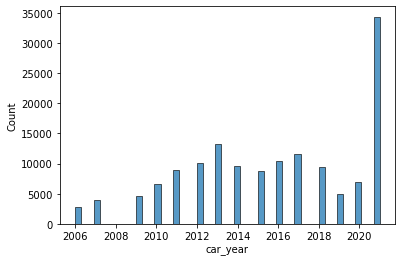

In [48]:
# Observamos cantidad de observaciones para cada año
# Logicamente, para años más recientes, en lineas generales tenemos mayor cantidad de casos
sns.histplot(df_meli_ok_cap['car_year'])

<AxesSubplot:xlabel='car_year', ylabel='Count'>

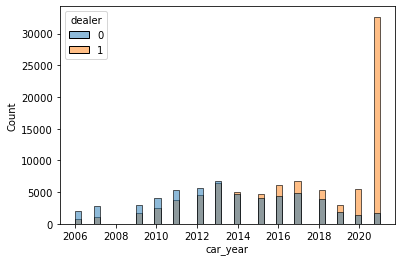

In [49]:
sns.histplot(data= df_meli_ok_cap, x='car_year',hue='dealer')

<AxesSubplot:xlabel='car_year', ylabel='Count'>

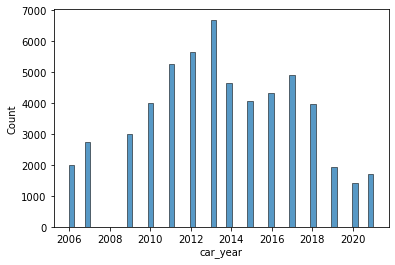

In [50]:
sns.histplot(data= df_meli_ok_cap[df_meli_ok_cap['dealer']==0], x='car_year')

In [51]:
df_meli_ok_cap.dealer.value_counts(1)

1   0.6148
0   0.3852
Name: dealer, dtype: float64

PROFUNDIZAR! <br>
Insight: la variable "car_year" sin contar los dealer=1, tiene una distribucion normal. Esto nos podría llevar a pensar en hacer modelos distintos para dealer=0 y dealer=1

<AxesSubplot:xlabel='car_year'>

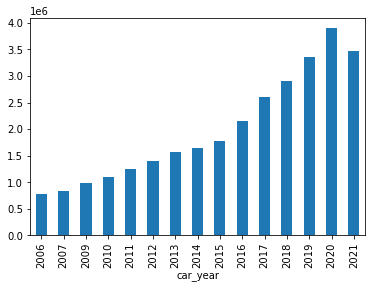

In [52]:
# Observamos la relacion año de fabricacion vs precio
df_meli_ok_cap.groupby('car_year')['price_meli_ok'].median().plot.bar()

<AxesSubplot:xlabel='car_year'>

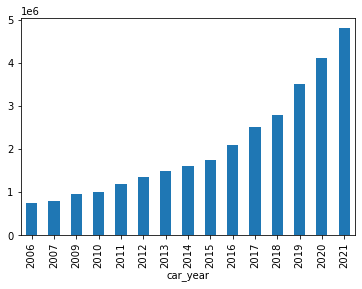

In [53]:
# Observamos la relacion año de fabricacion vs precio (filtrando los casos dealer=0)
df_meli_ok_cap[df_meli_ok_cap['dealer']==0].groupby('car_year')['price_meli_ok'].median().plot.bar()

Relacion perfectamente monotonica cuando sacamos los dealer=1. Esto va de la mano con el insight anterior

### Analisis: variables discretas <a id='section_vars_disc'></a>
Buscamos encontrar una relación con la variable target

In [54]:
df_meli_ok_cap[categ].nunique()

car_location_1    28
brand             41
dealer             2
dtype: int64

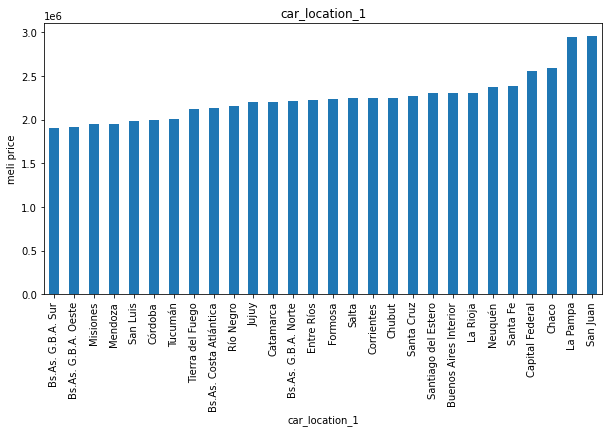

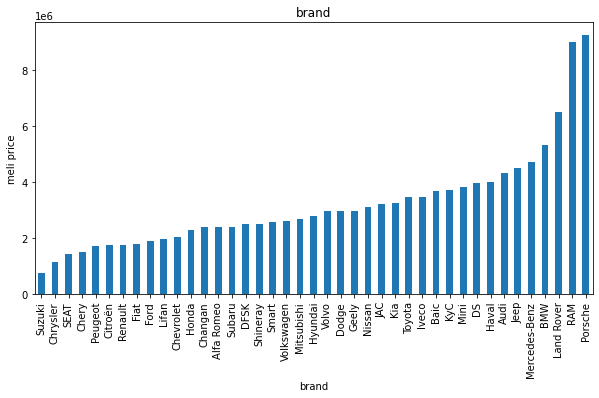

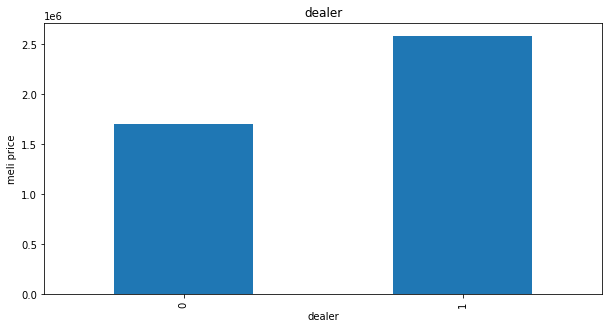

In [55]:
for feature in categ:
    data=df_meli_ok_cap.copy()
    plt.figure(figsize=(10,5))
    data.groupby(feature)['price_meli_ok'].median().sort_values().plot.bar()
    plt.xlabel(feature)
    plt.ylabel('meli price')
    plt.title(feature)
    plt.show()

### Analisis: variables continuas <a id='section_vars_conti'></a>
Buscamos encontrar una relación con la variable target

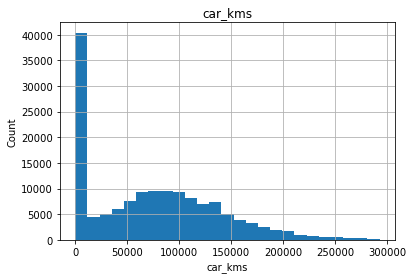

In [56]:
df_meli_ok_cap['car_kms'].hist(bins=25)
plt.xlabel('car_kms')
plt.ylabel("Count")
plt.title('car_kms')
plt.show()

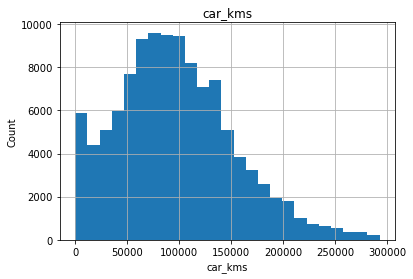

In [57]:
# Sin los 0km
df_meli_ok_cap[df_meli_ok_cap['car_kms']>0]['car_kms'].hist(bins=25)
plt.xlabel('car_kms')
plt.ylabel("Count")
plt.title('car_kms')
plt.show()

PROFUNDIZAR <br>
Insight: Hacer modelo separado para 0km (lo cual puede coincidir con dealer = 1) y otro modelo para los NO 0km

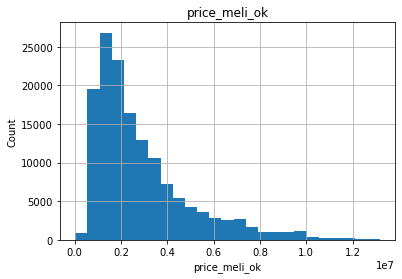

In [58]:
# Distribucion del target
df_meli_ok_cap['price_meli_ok'].hist(bins=25)
plt.xlabel('price_meli_ok')
plt.ylabel("Count")
plt.title('price_meli_ok')
plt.show()

Observamos que nuestras variables numericas tiene distribuciones asimetricas...<br>
Uno de los supuestos de la regresion lineal es que las variables input deben tener distribuciones gausseanas, es por eso que les vamos a aplicar logarithmic transformation a las variables continuas con el fin de llevarlas a una distribución normal.
Recordemos que la transformación se hará en la sección de feature engineering, ahora solo lo hacemos a modo de exploración

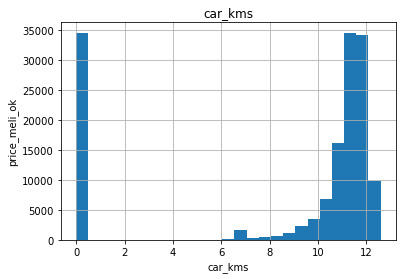

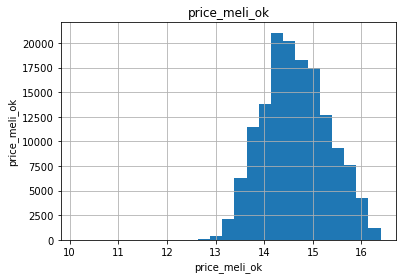

In [59]:
# Observamos como quedan las distribuciones de las variables input luego de la transformación
for feature in numeric+target:
    data=df_meli_ok_cap.copy()
    if data[feature].min() == 0:
        data[feature]=np.log(1+data[feature])
        data[feature].hist(bins=25)
        plt.xlabel(feature)
        plt.ylabel('price_meli_ok')
        plt.title(feature)
        plt.show()
    else:
        data[feature]=np.log(data[feature])
        data[feature].hist(bins=25)
        plt.xlabel(feature)
        plt.ylabel('price_meli_ok')
        plt.title(feature)
        plt.show()

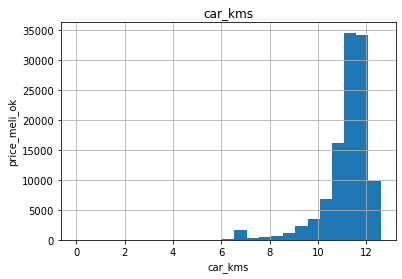

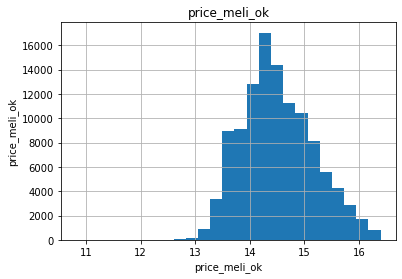

In [60]:
# Observamos como quedan las distribuciones de las variables input luego de la transformación
for feature in numeric+target:
    data=df_meli_ok_cap[df_meli_ok_cap['car_kms']>0].copy()
    if data[feature].min() == 0:
        data[feature]=np.log(1+data[feature])
        data[feature].hist(bins=25)
        plt.xlabel(feature)
        plt.ylabel('price_meli_ok')
        plt.title(feature)
        plt.show()
    else:
        data[feature]=np.log(data[feature])
        data[feature].hist(bins=25)
        plt.xlabel(feature)
        plt.ylabel('price_meli_ok')
        plt.title(feature)
        plt.show()

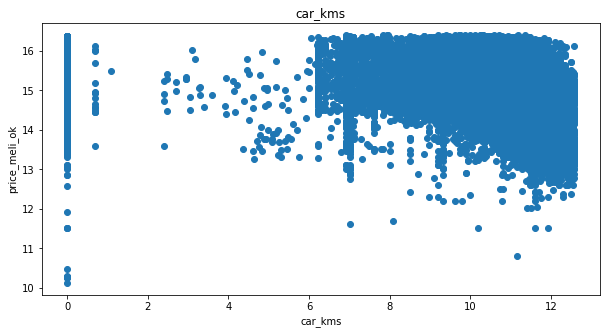

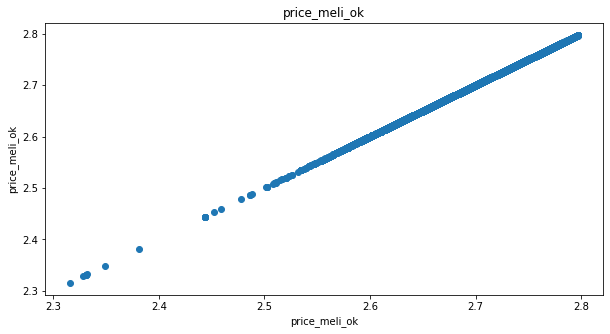

In [61]:
# Observamos como quedan las relaciones de las variables input con la variable target luego de la transformación
for feature in numeric+target:
    data=df_meli_ok_cap.copy()
    if data[feature].min() == 0:
        data[feature]=np.log(1+data[feature])
        data['price_meli_ok']=np.log(data['price_meli_ok'])
        plt.figure(figsize=(10,5))
        plt.scatter(data[feature],data['price_meli_ok'])
        plt.xlabel(feature)
        plt.ylabel('price_meli_ok')
        plt.title(feature)
        plt.show()
    else:
        data[feature]=np.log(data[feature])
        data['price_meli_ok']=np.log(data['price_meli_ok'])
        plt.figure(figsize=(10,5))
        plt.scatter(data[feature],data['price_meli_ok'])
        plt.xlabel(feature)
        plt.ylabel('price_meli_ok')
        plt.title(feature)
        plt.show()

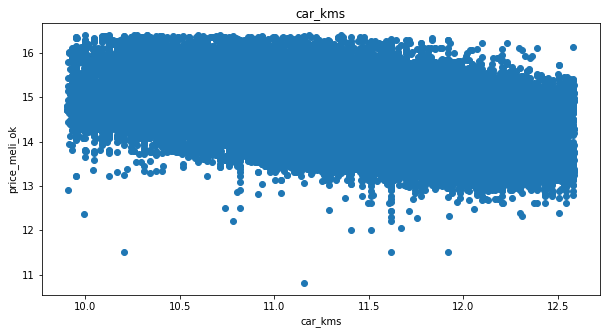

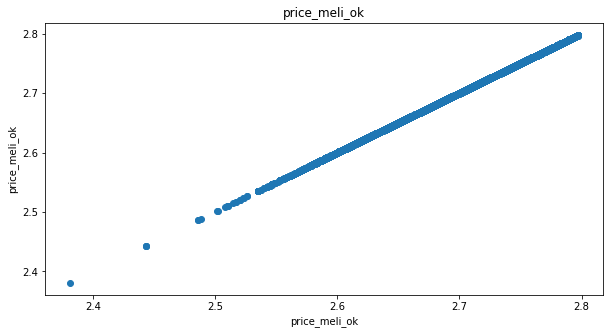

In [62]:
# Observamos como quedan las relaciones de las variables input con la variable target luego de la transformación
for feature in numeric+target:
    mask = df_meli_ok_cap['car_kms']>20000
    data=df_meli_ok_cap[mask].copy()
    if data[feature].min() == 0:
        data[feature]=np.log(1+data[feature])
        data['price_meli_ok']=np.log(data['price_meli_ok'])
        plt.figure(figsize=(10,10))
        plt.scatter(data[feature],data['price_meli_ok'])
        plt.xlabel(feature)
        plt.ylabel('price_meli_ok')
        plt.title(feature)
        plt.show()
    else:
        data[feature]=np.log(data[feature])
        data['price_meli_ok']=np.log(data['price_meli_ok'])
        plt.figure(figsize=(10,5))
        plt.scatter(data[feature],data['price_meli_ok'])
        plt.xlabel(feature)
        plt.ylabel('price_meli_ok')
        plt.title(feature)
        plt.show()

Hacerlo solamente con autos con mucha muestra y tambien con un solo auto o solo un año, etc para ver de encontrar donde se ensucia. porque la relacion lineal debería poder verse

**Correlacion contra el target**

In [63]:
# Primero observamos que importancia tienen las variables para contribuir a predecir el precio (target) con un modelo lineal
corrmat = df_meli_ok_cap[[col for col in df_meli_ok_cap.drop('dealer',1) if 'score' not in col]].corr()
#plt.figure(figsize=(14,18))
#plt.title("Features corr vs target")
#abs(corrmat['price_meli_ok']).sort_values(ascending=False)[1:].plot.bar()
#plt.show()
corrmat

,car_year,car_kms,price_meli_ok
car_year,1.0000,-0.8271,0.5049
car_kms,-0.8271,1.0000,-0.4557
price_meli_ok,0.5049,-0.4557,1.0000


Ojo que car_year y car_kms estan fuertemente correlacioandas entre sí (logicamente relacion inversa ya que si el año el mayor el auto es más nuevo y por lo tanto menos kms)

## Continuamos armando el train 

* Scores > 50 - OK
* Duplicado más reciente - OK
* Excluir 0km y concesionaria - OK
* Ultimos 15 dias - OK
* Registros de Brazil - OK

**Nos quedamos unicamente con los ultimos 15 dias**

In [64]:
df_meli_ok_cap.runtime.head()

1640282   2021-11-21 22:58:13
2018055   2021-11-21 23:00:25
2562531   2021-11-21 23:00:25
1361521   2021-11-21 23:00:25
2292449   2021-11-21 23:00:25
Name: runtime, dtype: datetime64[ns]

In [65]:
df_meli_ok_cap.runtime.max()

Timestamp('2021-12-19 23:01:17')

In [66]:
from datetime import date, datetime, timedelta
df_meli_ok_cap.runtime.max() - timedelta(days=10) 

Timestamp('2021-12-09 23:01:17')

In [67]:
max_date = df_meli_ok_cap.runtime.max()
mask_last15d = (df_meli_ok_cap.runtime <= max_date) & ((df_meli_ok_cap.runtime >= max_date - timedelta(days=15)))
df_meli_ok_cap = df_meli_ok_cap[mask_last15d]

In [68]:
print(df_meli_ok_cap.runtime.min())
print(df_meli_ok_cap.runtime.max())

2021-12-04 23:01:17
2021-12-19 23:01:17


**Excluímos 0km y concesionaria**

In [69]:
mask_not_0km = df_meli_ok_cap.car_kms > 90
mask_not_conces = df_meli_ok_cap.dealer == 0

df_meli_ok_cap = df_meli_ok_cap[(mask_not_0km) & (mask_not_conces)]

In [70]:
# Como nos quedamos con solamente un valor de la feature "dealer" la podemos eliminar7
df_meli_ok_cap.drop('dealer',1,inplace=True)

In [71]:
df_meli_ok_cap.shape

(43763, 30)

**Excluímos los registros con scores de matcheos menores a 50**

In [72]:
features_scores = [col for col in df_meli_ok_cap if ('score' in col) & ('total' not in col)]
features_scores

['score_marca_a',
 'score_modelo_a',
 'score_v1_a',
 'score_marca_c',
 'score_modelo_c',
 'score_v1_c']

In [73]:
lst = ['score_marca_a','score_modelo_a','score_v1_c']
for col in lst:
    df_meli_ok_cap = df_meli_ok_cap[df_meli_ok_cap[col]>=50]

In [74]:
# chequeo
df_meli_ok_cap[lst].min()

score_marca_a    92.0000
score_modelo_a   50.0000
score_v1_c       50.0000
dtype: float64

In [75]:
df_meli_ok_cap.shape

(40671, 30)

## Modelo baseline (borrador)

- sacamos los registros del interior
- agregamos segmento y subsegmento

In [76]:
df_meli_ok_cap.columns

Index(['runtime', 'car_year', 'car_kms', 'car_location_0', 'car_location_1',
       'car_id', 'brand', 'model', 'version', 'match_marca_a', 'score_marca_a',
       'match_modelo_a', 'score_modelo_a', 'match_v1_a', 'score_v1_a',
       'total_score_a', 'Seg_a', 'Subseg_a', 'gama_a', 'match_marca_c',
       'score_marca_c', 'match_modelo_c', 'score_modelo_c', 'match_v1_c',
       'score_v1_c', 'total_score_c', 'Seg_c', 'Subseg_c', 'gama_c',
       'price_meli_ok'],
      dtype='object')

In [77]:
df_meli_ok_cap.nunique()

runtime            4002
car_year             15
car_kms            3175
car_location_0      460
car_location_1       28
car_id            40671
brand                36
model               415
version            5879
match_marca_a        36
score_marca_a         2
match_modelo_a      338
score_modelo_a       17
match_v1_a         2350
score_v1_a           91
total_score_a       359
Seg_a                 7
Subseg_a             25
gama_a                3
match_marca_c        35
score_marca_c         3
match_modelo_c      303
score_modelo_c       18
match_v1_c         1785
score_v1_c           50
total_score_c       203
Seg_c                 9
Subseg_c             27
gama_c                3
price_meli_ok      2087
dtype: int64

In [78]:
df_meli_ok_cap.car_location_1.value_counts()

Capital Federal           6793
Bs.As. G.B.A. Sur         6690
Bs.As. G.B.A. Norte       6030
Bs.As. G.B.A. Oeste       5112
Córdoba                   3908
Buenos Aires Interior     3044
Santa Fe                  1748
Bs.As. Costa Atlántica    1269
Mendoza                    943
Entre Ríos                 737
Neuquén                    589
Tucumán                    548
Río Negro                  418
Misiones                   369
Corrientes                 336
Chaco                      322
San Luis                   318
Salta                      249
Chubut                     246
La Pampa                   184
San Juan                   142
Santiago del Estero        123
Catamarca                  116
Santa Cruz                 101
Formosa                    100
Jujuy                       94
Tierra del Fuego            73
La Rioja                    69
Name: car_location_1, dtype: int64

In [79]:
df_meli_ok_cap.shape

(40671, 30)

In [80]:
cats_ok = ['Capital Federal','Bs.As. G.B.A. Sur','Bs.As. G.B.A. Norte'
           ,'Bs.As. G.B.A. Oeste','Buenos Aires Interior','Bs.As. Costa Atlántica']
mask = df_meli_ok_cap.car_location_1.apply(lambda x: x in cats_ok)
df_meli_final = df_meli_ok_cap[mask]

In [81]:
df_meli_final.shape

(28938, 30)

In [82]:
final_features = ['car_year','car_kms','match_marca_a','match_modelo_a'
                  ,'match_v1_c', 'Subseg_a', 'Seg_a'
                  ,'price_meli_ok']
df_meli_final = df_meli_final[final_features]

In [83]:
df_meli_final['car_year']=df_meli_final['car_year'].astype('float')

In [84]:
df_meli_final.dtypes

car_year          float64
car_kms           float64
match_marca_a      object
match_modelo_a     object
match_v1_c         object
Subseg_a           object
Seg_a              object
price_meli_ok     float64
dtype: object

In [85]:
df_meli_final.head()

,car_year,car_kms,match_marca_a,match_modelo_a,match_v1_c,Subseg_a,Seg_a,price_meli_ok
2956496,2007.0000,62000.0000,FORD,KA,TATTOO PLUS 1.6L,Gama Pequenos Hatchback,Gama Pequenos,722080.0000
2131107,2018.0000,58000.0000,NISSAN,Kicks,ADVANCE MT,Suv Compactas 4x2,SUV,3400000.0000
2218325,2017.0000,36000.0000,TOYOTA,Corolla,SE-G 1.8 CVT,Gama Pequenos Hatchback,Gama Pequenos,3350000.0000
2751519,2013.0000,181000.0000,HONDA,Civic,EXS,Gama Medianos Sedan,Gama Medianos,1650000.0000
45811,2017.0000,80000.0000,TOYOTA,Corolla,SE-G 1.8 CVT,Gama Pequenos Hatchback,Gama Pequenos,2947500.0000


In [99]:
df_meli_final.shape

(28938, 8)

In [96]:
categorical_features_indices = np.where(df_meli_final.dtypes != np.float)[0]

In [87]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split

In [88]:
X_train, X_test, y_train, y_test = train_test_split(df_meli_final.drop('price_meli_ok',1), df_meli_final.price_meli_ok, train_size=0.8, random_state=42)

model=CatBoostRegressor(iterations=50, depth=3, learning_rate=0.1, loss_function='RMSE') #,logging_level="Silent"
model.fit(X_train, y_train, cat_features=categorical_features_indices, eval_set=(X_test, y_test))

test_preds = model.predict(X_test)
train_preds = model.predict(X_train)

from catboost.utils import eval_metric

print("\nTest  R2 : %.3f"%model.score(X_test, y_test))
print("Train R2 : %.3f"%model.score(X_train, y_train))

0:	learn: 1642312.3308506	test: 1634155.2755472	best: 1634155.2755472 (0)	total: 162ms	remaining: 7.94s
1:	learn: 1552596.9245457	test: 1545522.6753360	best: 1545522.6753360 (1)	total: 177ms	remaining: 4.25s
2:	learn: 1472786.8270504	test: 1468236.2128067	best: 1468236.2128067 (2)	total: 198ms	remaining: 3.1s
3:	learn: 1402656.8481610	test: 1400015.0660412	best: 1400015.0660412 (3)	total: 212ms	remaining: 2.43s
4:	learn: 1341439.6578956	test: 1337488.5910640	best: 1337488.5910640 (4)	total: 226ms	remaining: 2.03s
5:	learn: 1285077.6353269	test: 1279582.3057183	best: 1279582.3057183 (5)	total: 241ms	remaining: 1.77s
6:	learn: 1234359.3213002	test: 1227206.8447050	best: 1227206.8447050 (6)	total: 251ms	remaining: 1.54s
7:	learn: 1190282.3750908	test: 1182292.1797333	best: 1182292.1797333 (7)	total: 261ms	remaining: 1.37s
8:	learn: 1148742.0111674	test: 1139890.5308067	best: 1139890.5308067 (8)	total: 270ms	remaining: 1.23s
9:	learn: 1115126.2371952	test: 1107041.5786894	best: 1107041.578

In [97]:
########### prueba sin el eval_test parameter ##########
X_train, X_test, y_train, y_test = train_test_split(df_meli_final.drop('price_meli_ok',1), df_meli_final.price_meli_ok, train_size=0.8, random_state=42)

model=CatBoostRegressor(iterations=50, depth=3, learning_rate=0.1, loss_function='RMSE') #,logging_level="Silent"
model.fit(X_train, y_train, cat_features=categorical_features_indices)

test_preds = model.predict(X_test)
train_preds = model.predict(X_train)

from catboost.utils import eval_metric

print("\nTest  R2 : %.3f"%model.score(X_test, y_test))
print("Train R2 : %.3f"%model.score(X_train, y_train))

0:	learn: 1642312.3308506	total: 32.3ms	remaining: 1.58s
1:	learn: 1552596.9245457	total: 45.9ms	remaining: 1.1s
2:	learn: 1472786.8270504	total: 56.6ms	remaining: 886ms
3:	learn: 1402656.8481610	total: 65.7ms	remaining: 756ms
4:	learn: 1341439.6578956	total: 76.3ms	remaining: 686ms
5:	learn: 1285077.6353269	total: 87ms	remaining: 638ms
6:	learn: 1234359.3213002	total: 98.1ms	remaining: 603ms
7:	learn: 1190282.3750908	total: 107ms	remaining: 564ms
8:	learn: 1148742.0111674	total: 117ms	remaining: 532ms
9:	learn: 1115126.2371952	total: 127ms	remaining: 507ms
10:	learn: 1082911.7120409	total: 136ms	remaining: 483ms
11:	learn: 1056060.9606448	total: 145ms	remaining: 460ms
12:	learn: 1030396.7849885	total: 154ms	remaining: 439ms
13:	learn: 1008144.4573640	total: 163ms	remaining: 420ms
14:	learn: 989718.4626620	total: 172ms	remaining: 402ms
15:	learn: 970270.2792311	total: 183ms	remaining: 389ms
16:	learn: 953336.2347983	total: 194ms	remaining: 376ms
17:	learn: 939872.3204988	total: 203ms	r

In [98]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,Subseg_a,33.6918
1,car_year,21.6526
2,car_kms,13.5866
3,match_modelo_a,12.5520
4,match_marca_a,11.2937
5,Seg_a,6.3074
6,match_v1_c,0.9158


In [91]:
# Save del pipe

import pickle
with open('model_catboost.pickle', 'wb') as f:
    pickle.dump(model, f)